In [3]:

import pandas as pd
import nltk
import spacy
nlp = spacy.load('en_core_web_sm')
import tensorflow
import numpy as np


from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# Load the JSONL file into a pandas DataFrame
df = pd.read_json('data.jsonl', lines=True)

In [5]:
df.head()

,response
0,"""Compare and contrast the philosophical founda..."
1,What are the key differences between classicis...
2,"Analyze the significance of the concept of ""co..."
3,"""Compare and contrast two different theories r..."
4,"""Analyze and discuss the role of artificial in..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   response  250000 non-null  object
dtypes: object(1)
memory usage: 1.9+ MB


# **Data Cleaning**

By inspecting the dataset, I discovered some rows that have the same word repeated many times. This needs to be cleaned by dropping these rows.

Below is an example of some of these rows:

In [7]:
# Adjust display options to show full content of DataFrame column
pd.set_option('display.max_colwidth', 200)

#Check rows with repeated values
repeated_rows = df[df['response'].str.contains(r'\b(\w+)\s+\1\s+\1\s+\1\b')]
print(repeated_rows)

<ipython-input-7-fc6e1fa13723>:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  repeated_rows = df[df['response'].str.contains(r'\b(\w+)\s+\1\s+\1\s+\1\b')]


                                                                                                                                                                                                       response
14875   How does the concept of paradoxical paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox paradox ...
68210                "Compare and contrast the key theories periodically periodically proposed in the history of X period (e.g period period period period period period period period period period period )."
82552   Explain the defining characteristics of an Empirical Research Study defining Empirical defining Research Research Study Study defining defining defining defining defining defining defining definin...
111862  Compare everyday everyday everyday everyday everyday everyday everyday everyday everyday everyday everyday everyday everyday everyday everyday everyday everyday

I will drop any row that has the same word repeated more than 4 times

In [8]:
# Dropping rows that have the same word repeated more than 4 times
def drop_repeated_words(df, max_repeats=4):

    # Splitting each row's text into words
    words = df['response'].str.split()

    # Checking for repeated words
    repeated_indices = []
    for i, row_words in enumerate(words):
        word_counts = {}
        for word in row_words:
            word_counts[word] = word_counts.get(word, 0) + 1
            if word_counts[word] > max_repeats:
                repeated_indices.append(i)
                break


    df.drop(repeated_indices, inplace=True)


In [9]:
drop_repeated_words(df)

In [10]:
# Now the prompts are 249118 instead of 250,000
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249118 entries, 0 to 249999
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   response  249118 non-null  object
dtypes: object(1)
memory usage: 3.8+ MB


In [11]:
# There are no null values
df.isnull().sum()

response    0
dtype: int64

In [12]:
# Get the length of each prompt
df['prompt_length'] = df['response'].apply(lambda x: len(x.split()))
df['prompt_length']

0         20
1         13
2         19
3         12
4         13
          ..
249995    22
249996    22
249997    21
249998    13
249999    19
Name: prompt_length, Length: 249118, dtype: int64

In [13]:
# basic statistics of prompt lengths
df['prompt_length'].describe()

count    249118.000000
mean         16.648291
std           4.436962
min           2.000000
25%          14.000000
50%          16.000000
75%          19.000000
max          76.000000
Name: prompt_length, dtype: float64

In [14]:
import re

# Remove special characters and non-alphanumeric characters
df['response'] = df['response'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

In [15]:
# Remove leading and trailing whitespaces
df['response'] = df['response'].apply(lambda x: x.strip())

# **Data Preprocessing**

In [16]:
# Tokenization
def preprocessing(text):
    doc = nlp(text)

    # Extract tokens from the SpaCy document
    tokens = [token.text for token in doc]
    return tokens

df['tokens'] = df['response'].apply(preprocessing)


In [17]:
df

,response,prompt_length,tokens
0,Compare and contrast the philosophical foundations of two major schools of thought in the field of psychology Behaviorism and Cognitivism,20,"[Compare, and, contrast, the, philosophical, foundations, of, two, major, schools, of, thought, in, the, field, of, psychology, Behaviorism, and, Cognitivism]"
1,What are the key differences between classicism and romanticism in literature and art,13,"[What, are, the, key, differences, between, classicism, and, romanticism, in, literature, and, art]"
2,Analyze the significance of the concept of cognitive dissonance in social psychology and its implications for understanding human behavior,19,"[Analyze, the, significance, of, the, concept, of, cognitive, dissonance, in, social, psychology, and, its, implications, for, understanding, human, behavior]"
3,Compare and contrast two different theories related to human development in psychology,12,"[Compare, and, contrast, two, different, theories, related, to, human, development, in, psychology]"
4,Analyze and discuss the role of artificial intelligence in the future of education,13,"[Analyze, and, discuss, the, role, of, artificial, intelligence, in, the, future, of, education]"
...,...,...,...
249995,What is the significance of the concept of homeostasis in biology and how does it relate to the functioning of biological systems,22,"[What, is, the, significance, of, the, concept, of, homeostasis, in, biology, and, how, does, it, relate, to, the, functioning, of, biological, systems]"
249996,Discuss the role of cellular respiration in energy production within living organisms and how it contributes to the overall functioning of cells,22,"[Discuss, the, role, of, cellular, respiration, in, energy, production, within, living, organisms, and, how, it, contributes, to, the, overall, functioning, of, cells]"
249997,In the field of artificial intelligence explain the difference between supervised and unsupervised learning and provide a reallife example of each,21,"[In, the, field, of, artificial, intelligence, explain, the, difference, between, supervised, and, unsupervised, learning, and, provide, a, reallife, example, of, each]"
249998,Compare and contrast the key differences between Classical and Quantum Mechanics in physics,13,"[Compare, and, contrast, the, key, differences, between, Classical, and, Quantum, Mechanics, in, physics]"


In [18]:
# Lemmatization
lemmatized_responses = []

for token in df['tokens']:
    doc = nlp(" ".join(token))
    lemmatized_response = [token.lemma_ for token in doc]
    lemmatized_responses.append(lemmatized_response)

In [19]:
lemmatized_responses[0]

['compare',
 'and',
 'contrast',
 'the',
 'philosophical',
 'foundation',
 'of',
 'two',
 'major',
 'school',
 'of',
 'thought',
 'in',
 'the',
 'field',
 'of',
 'psychology',
 'Behaviorism',
 'and',
 'Cognitivism']

In [20]:
# Remove Stop words
filtered_responses = []
for response in lemmatized_responses:
    filtered_response = [token for token in response if not nlp.vocab[token].is_stop]
    filtered_responses.append(filtered_response)


In [21]:
filtered_responses[0]

['compare',
 'contrast',
 'philosophical',
 'foundation',
 'major',
 'school',
 'thought',
 'field',
 'psychology',
 'Behaviorism',
 'Cognitivism']

In [22]:
# Responses after removing stop words.
df['filtered_response'] = filtered_responses

In [23]:
df.head()

,response,prompt_length,tokens,filtered_response
0,Compare and contrast the philosophical foundations of two major schools of thought in the field of psychology Behaviorism and Cognitivism,20,"[Compare, and, contrast, the, philosophical, foundations, of, two, major, schools, of, thought, in, the, field, of, psychology, Behaviorism, and, Cognitivism]","[compare, contrast, philosophical, foundation, major, school, thought, field, psychology, Behaviorism, Cognitivism]"
1,What are the key differences between classicism and romanticism in literature and art,13,"[What, are, the, key, differences, between, classicism, and, romanticism, in, literature, and, art]","[key, difference, classicism, romanticism, literature, art]"
2,Analyze the significance of the concept of cognitive dissonance in social psychology and its implications for understanding human behavior,19,"[Analyze, the, significance, of, the, concept, of, cognitive, dissonance, in, social, psychology, and, its, implications, for, understanding, human, behavior]","[analyze, significance, concept, cognitive, dissonance, social, psychology, implication, understand, human, behavior]"
3,Compare and contrast two different theories related to human development in psychology,12,"[Compare, and, contrast, two, different, theories, related, to, human, development, in, psychology]","[compare, contrast, different, theory, relate, human, development, psychology]"
4,Analyze and discuss the role of artificial intelligence in the future of education,13,"[Analyze, and, discuss, the, role, of, artificial, intelligence, in, the, future, of, education]","[analyze, discuss, role, artificial, intelligence, future, education]"


In [24]:
# Remove punctuation
punctuations = "?:!.,;"
filtered_responses_without_punctuation = []

for response in filtered_responses:
    filtered_response = [word for word in response if word not in punctuations]
    filtered_responses_without_punctuation.append(filtered_response)

In [25]:
filtered_responses_without_punctuation[0]

['compare',
 'contrast',
 'philosophical',
 'foundation',
 'major',
 'school',
 'thought',
 'field',
 'psychology',
 'Behaviorism',
 'Cognitivism']

In [26]:
# POS tagging
def pos_tagging(filtered_responses):
    tagged_responses = []
    for response in filtered_responses:
        doc = nlp(" ".join(response))
        tagged_response = [(token.text, token.pos_) for token in doc]
        tagged_responses.append(tagged_response)
    return tagged_responses

tagged_responses = pos_tagging(filtered_responses)

In [27]:
# Named Entity Recognition (NER)
# def ner_tagging(filtered_responses):
#     tagged_responses = []
#     for response in filtered_responses:
#         doc = nlp(" ".join(response))
#         tagged_response = [(ent.text, ent.label_) for ent in doc.ents]
#         tagged_responses.append(tagged_response)
#     return tagged_responses

# ner_tagged_responses = ner_tagging(filtered_responses)

In [28]:
df['pos_results'] = tagged_responses
df.head()

,response,prompt_length,tokens,filtered_response,pos_results
0,Compare and contrast the philosophical foundations of two major schools of thought in the field of psychology Behaviorism and Cognitivism,20,"[Compare, and, contrast, the, philosophical, foundations, of, two, major, schools, of, thought, in, the, field, of, psychology, Behaviorism, and, Cognitivism]","[compare, contrast, philosophical, foundation, major, school, thought, field, psychology, Behaviorism, Cognitivism]","[(compare, VERB), (contrast, NOUN), (philosophical, ADJ), (foundation, NOUN), (major, ADJ), (school, NOUN), (thought, VERB), (field, NOUN), (psychology, NOUN), (Behaviorism, PROPN), (Cognitivism, ..."
1,What are the key differences between classicism and romanticism in literature and art,13,"[What, are, the, key, differences, between, classicism, and, romanticism, in, literature, and, art]","[key, difference, classicism, romanticism, literature, art]","[(key, ADJ), (difference, NOUN), (classicism, NOUN), (romanticism, NOUN), (literature, PROPN), (art, NOUN)]"
2,Analyze the significance of the concept of cognitive dissonance in social psychology and its implications for understanding human behavior,19,"[Analyze, the, significance, of, the, concept, of, cognitive, dissonance, in, social, psychology, and, its, implications, for, understanding, human, behavior]","[analyze, significance, concept, cognitive, dissonance, social, psychology, implication, understand, human, behavior]","[(analyze, VERB), (significance, NOUN), (concept, NOUN), (cognitive, ADJ), (dissonance, NOUN), (social, ADJ), (psychology, NOUN), (implication, NOUN), (understand, VERB), (human, ADJ), (behavior, ..."
3,Compare and contrast two different theories related to human development in psychology,12,"[Compare, and, contrast, two, different, theories, related, to, human, development, in, psychology]","[compare, contrast, different, theory, relate, human, development, psychology]","[(compare, VERB), (contrast, NOUN), (different, ADJ), (theory, NOUN), (relate, VERB), (human, PROPN), (development, NOUN), (psychology, NOUN)]"
4,Analyze and discuss the role of artificial intelligence in the future of education,13,"[Analyze, and, discuss, the, role, of, artificial, intelligence, in, the, future, of, education]","[analyze, discuss, role, artificial, intelligence, future, education]","[(analyze, VERB), (discuss, VERB), (role, NOUN), (artificial, ADJ), (intelligence, NOUN), (future, ADJ), (education, NOUN)]"


# **Data Analysis and insights**

In [29]:
# This method returns a list of all the words in the dataset after removing stopwords, removing punctuation, lowercasing, and lemmatization

def extract_vocab(filtered_responses):
    vocab = set()
    for response in filtered_responses:
        for word in response:
            vocab.add(word)
    return list(vocab)


In [30]:
# My Vocab
# Word_list contains all the words "Vocab" of my dataset
words_list = extract_vocab(filtered_responses)

# Example of some of the words
words_list[0:30]

['paradigm',
 'Samsa',
 'Lavoisier',
 'grow',
 'operationalization',
 'welldevelope',
 'ofBehaviorism',
 'typically',
 'Narratology',
 'completing',
 'bx',
 'QuineDu',
 'review',
 'Compare',
 'amplitude',
 'double',
 'turnover',
 'wild',
 'gerontology',
 'threesentence',
 'Assess',
 'hormesis',
 'uncertainty',
 'orientation',
 'maslow',
 'vast',
 'enhanced',
 'schizophrenia',
 'Communicative',
 'Schopenhauers']

In [31]:
# This methods returns a dictionary where each 'key' is a word in the dataset and each 'value' is the frequency of that word in the dataset.
def termFrequency(filtered_responses):
    term_freq_dict = {}
    for response in filtered_responses:
        for word in response:
            if word not in nlp.Defaults.stop_words:  # Check if word is not a stop word
                term_freq_dict[word] = term_freq_dict.get(word, 0) + 1
    return term_freq_dict

In [32]:
#word_freq_dict having each word in the dataset and it's corresponding count
term_freq = termFrequency(filtered_responses)
sorted_term_freq = dict(sorted(term_freq.items(), key=lambda item: item[1], reverse=True))

# Take only the top 10 items
top_10_term_freq = dict(list(sorted_term_freq.items())[:10])

top_10_term_freq

{'compare': 57516,
 'significance': 57396,
 'contrast': 57024,
 'field': 56935,
 'theory': 56283,
 'explain': 54501,
 'key': 53012,
 'concept': 42367,
 'difference': 38508,
 'development': 35789}

In [33]:
# Getting the most frequent word
def most_frequent_word(term_freq_dict):

    max_freq_word = max(term_freq_dict, key=term_freq_dict.get)
    max_freq = term_freq_dict[max_freq_word]
    return max_freq_word, max_freq

most_freq_word, freq = most_frequent_word(term_freq)
print("Most frequent word:", most_freq_word)
print("Frequency:", freq)

Most frequent word: compare
Frequency: 57516


As we can see, the most frquent word is **"Compare"**. This can provide insights about our data that most of the prompts focus on  comparisons between different entities, concepts, ideas, or phenomena.

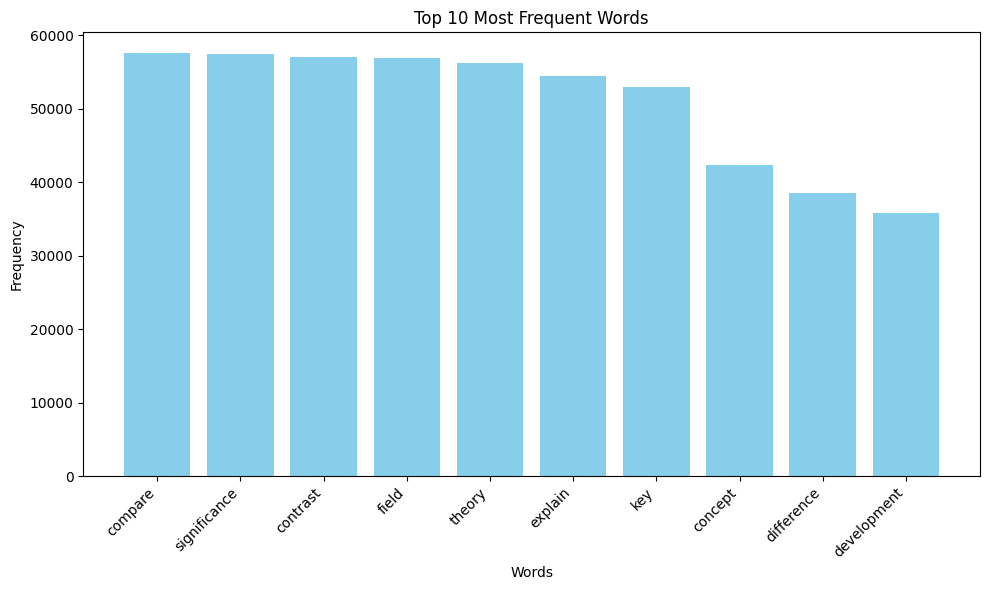

In [34]:
import matplotlib.pyplot as plt

def plot_top_10_words(term_freq_dict):

    sorted_freq = sorted(term_freq_dict.items(), key=lambda x: x[1], reverse=True)


    top_10_words = sorted_freq[:10]


    words = [item[0] for item in top_10_words]
    frequencies = [item[1] for item in top_10_words]


    plt.figure(figsize=(10, 6))
    plt.bar(words, frequencies, color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Top 10 Most Frequent Words')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
plot_top_10_words(term_freq)

In [35]:
# This method calculates the docunemt frequency of each word, which means how many prompts contain each word.
def wordDocFreq(filtered_responses):
    doc_freq_dict = {}
    for response in filtered_responses:
        seen_words = set()
        for word in response:
            if word not in seen_words:
                doc_freq_dict[word] = doc_freq_dict.get(word, 0) + 1
                seen_words.add(word)
    return doc_freq_dict

In [36]:
doc_freq = wordDocFreq(filtered_responses)
sorted_doc_freq = dict(sorted(doc_freq.items(), key=lambda item: item[1], reverse=True))

# Take only the top 10 items
top_10_doc_freq = dict(list(sorted_doc_freq.items())[:10])

top_10_doc_freq

{'compare': 57516,
 'significance': 57396,
 'contrast': 56974,
 'field': 56809,
 'explain': 54482,
 'theory': 54240,
 'key': 53002,
 'concept': 42281,
 'difference': 37749,
 'development': 35407}

In [37]:
# Finding the word with the highest document frequency count
def word_with_highest_doc_freq(doc_freq_dict):

    max_freq_word = max(doc_freq_dict, key=doc_freq_dict.get)
    max_freq = doc_freq_dict[max_freq_word]
    return max_freq_word, max_freq


max_freq_word, freq = word_with_highest_doc_freq(doc_freq)
print("Word with highest document frequency:", max_freq_word)
print("Document Frequency:", freq)

Word with highest document frequency: compare
Document Frequency: 57516


Again, "**Compare**" has the highest document frequency. This again means that most of the documents contain questions in the form of comparison

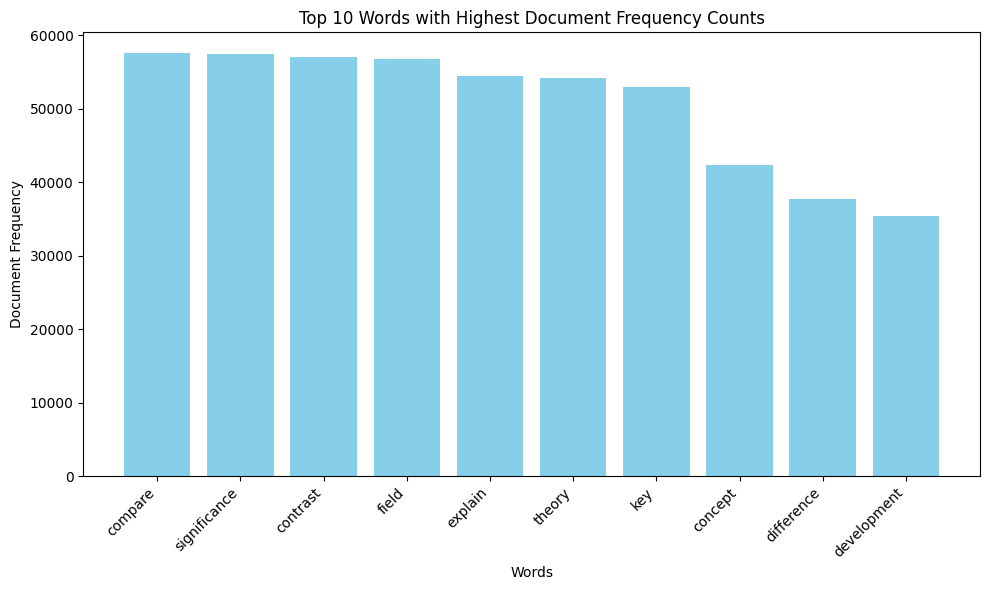

In [38]:
import matplotlib.pyplot as plt

sorted_doc_freq = sorted(doc_freq.items(), key=lambda x: x[1], reverse=True)


top_10_words = sorted_doc_freq[:10]


words = [item[0] for item in top_10_words]
frequencies = [item[1] for item in top_10_words]


plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Document Frequency')
plt.title('Top 10 Words with Highest Document Frequency Counts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [39]:
# This function calculates the IDF score for each word in the entire dataset
# The IDF score indicates how unique or important each word is relative to the entire corpus of documents.
import math

def calculate_idf(filtered_responses):
    total_documents = len(filtered_responses)
    word_document_count = {}

    for response in filtered_responses:
        seen_words = set()
        for word in response:
            if word not in seen_words:
                word_document_count[word] = word_document_count.get(word, 0) + 1
                seen_words.add(word)


    idf_scores = {}
    for word, doc_count in word_document_count.items():
        idf_scores[word] = math.log(total_documents / (doc_count + 1))

    return idf_scores

The IDF score indicates how unique or important each word is relative to the entire corpus of documents

In [40]:
#IDF score for each word
idf_scores = calculate_idf(filtered_responses)
sorted_idf_scores = dict(sorted(idf_scores.items(), key=lambda item: item[1], reverse=True))

# Take only the top 10 items
top_10_idf_scores = dict(list(idf_scores.items())[:10])

top_10_idf_scores

{'compare': 1.465846123513262,
 'contrast': 1.4753141046622402,
 'philosophical': 2.5594290928502232,
 'foundation': 3.867538781030934,
 'major': 3.7083272924376023,
 'school': 5.537109499210763,
 'thought': 4.682412257947121,
 'field': 1.4782143132249528,
 'psychology': 2.5559063207255335,
 'Behaviorism': 5.944104829499694}

In [41]:
# Finding the word with the highest IDF score
max_idf_word = max(idf_scores, key=idf_scores.get)
max_idf_score = idf_scores[max_idf_word]

print("Word with highest IDF score:", max_idf_word)
print("IDF Score:", max_idf_score)

Word with highest IDF score: connectionism
IDF Score: 11.73253477821618


The IDF score reflects how much information the word provides.The higher the IDF score, the more rare or unique the word is, and therefore, it's considered more important or significant in distinguishing between documents.

Words with high IDF scores are often indicative of terms that are crucial for understanding specific topics or concepts in the dataset. **"connectionism"** may be a key concept within psychology or cognitive science

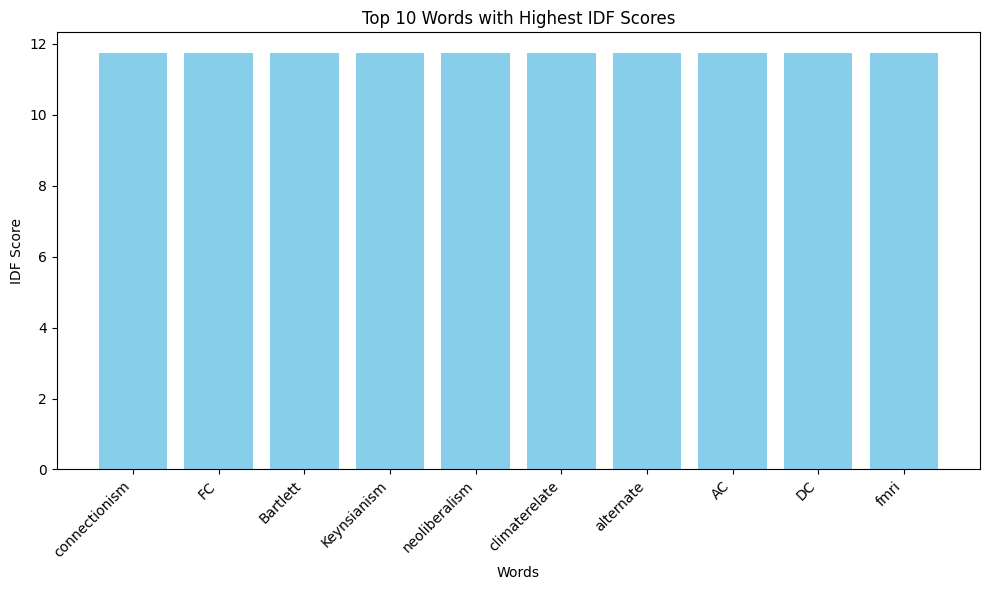

In [42]:
import matplotlib.pyplot as plt

sorted_idf_scores = sorted(idf_scores.items(), key=lambda x: x[1], reverse=True)

top_10_words = sorted_idf_scores[:10]

words = [item[0] for item in top_10_words]
idf_scores = [item[1] for item in top_10_words]

plt.figure(figsize=(10, 6))
plt.bar(words, idf_scores, color='skyblue')
plt.xlabel('Words')
plt.ylabel('IDF Score')
plt.title('Top 10 Words with Highest IDF Scores')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [43]:
#This function Calculates the TF-IDF score for each word in each preprocessed response individually.
import math

def calculate_tf_idf(filtered_responses):
    # Calculate TF (Term Frequency)
    tf_scores = {}
    for response in filtered_responses:
        for word in response:
            tf_scores[word] = tf_scores.get(word, 0) + 1

    # Calculate IDF (Inverse Document Frequency)
    total_documents = len(filtered_responses)
    word_document_count = {}
    for response in filtered_responses:
        seen_words = set()  # Keep track of words already seen in the current response
        for word in response:
            if word not in seen_words:  # Only count each word once per response
                word_document_count[word] = word_document_count.get(word, 0) + 1
                seen_words.add(word)

    idf_scores = {}
    for word, doc_count in word_document_count.items():
        idf_scores[word] = math.log(total_documents / (doc_count + 1))  # Add 1 to avoid division by zero

    # Calculate TF-IDF (Term Frequency-Inverse Document Frequency)
    tf_idf_scores = {}
    for word, tf_score in tf_scores.items():
        tf_idf_scores[word] = tf_score * idf_scores.get(word, 0)

    return tf_idf_scores

The TF-IDF score is a statistical measure used to evaluate the importance of a word in a document relative to a collection of document.

a high TF-IDF score for a word in a document indicates that the word is both frequent within that document and rare across the entire corpus, making it more likely to be relevant to the content of that document.

In [44]:
tf_idf_scores = calculate_tf_idf(filtered_responses)
sorted_tf_idf_scores = dict(sorted(tf_idf_scores.items(), key=lambda item: item[1], reverse=True))

# Take only the top 10 items
top_10_tf_idf_scores = dict(list(tf_idf_scores.items())[:10])

top_10_tf_idf_scores

{'compare': 84309.60563998877,
 'contrast': 84128.31150425959,
 'philosophical': 49402.10035019501,
 'foundation': 20149.877049171166,
 'major': 22654.17142950131,
 'school': 5470.664185220234,
 'thought': 10811.689903599901,
 'field': 84162.13192346269,
 'psychology': 50392.24901942462,
 'Behaviorism': 3875.5563488338007}

In [45]:
# Finding the highest TF-IDF score
max_tfidf_word = max(tf_idf_scores, key=tf_idf_scores.get)
max_tfidf_score = tf_idf_scores[max_tfidf_word]

print("Word with highest TF-IDF score:", max_tfidf_word)
print("TF-IDF Score:", max_tfidf_score)

Word with highest TF-IDF score: theory
TF-IDF Score: 85802.8481429335


A high TF-IDF score suggests that the word **"theory"** is significant and representative of the content in the dataset. It indicates that **"theory**" appears frequently in some documents (high TF) but is relatively rare across the entire dataset (high IDF), making it a distinguishing term.

Moreover, The presence of **"theory"** as the word with the highest TF-IDF score may indicate that the dataset contains documents with a strong focus on theoretical concepts or discussions. It suggests that the topic or theme revolving around **"theory"** is central to the dataset.

In [46]:
# Finding the top 10 highest TF-IDF scores
sorted_tf_idf_scores = sorted(tf_idf_scores.items(), key=lambda x: x[1], reverse=True)

top_10_words = sorted_tf_idf_scores[:10]

for i, (word, score) in enumerate(top_10_words, 1):
    print(f"{i}. Word: {word}, TF-IDF Score: {score}")

1. Word: theory, TF-IDF Score: 85802.8481429335
2. Word: compare, TF-IDF Score: 84309.60563998877
3. Word: significance, TF-IDF Score: 84253.57674911941
4. Word: field, TF-IDF Score: 84162.13192346269
5. Word: contrast, TF-IDF Score: 84128.31150425959
6. Word: explain, TF-IDF Score: 82843.58849768207
7. Word: key, TF-IDF Score: 82040.21363369022
8. Word: concept, TF-IDF Score: 75140.63751563714
9. Word: difference, TF-IDF Score: 72662.33188744255
10. Word: development, TF-IDF Score: 69823.94161631221


# **Neural Network model**

 Assigning a unique index to each word in my dataset.

In [47]:
# Create a vocabulary dictionary to map words to indices
vocab = {}
index = 0

# Iterate through each word in the vocabulary list
for word in words_list:
    # Check if the word is not already in the vocabulary
    if word not in vocab:
        # Assign the current index to the word and increment the index
        vocab[word] = index
        index += 1

In [48]:
# Set the dimensionality of the embedding space
embedding_dim = 200

 Map Tokens to Indices

In [49]:
def tokens_to_indices(tokens, vocab):
    indices = []
    # Iterate through each token in the tokenized sequence
    for token in tokens:
        # Check if the token exists in the vocabulary
        if token in vocab:
            # Map the token to its corresponding index in the vocabulary
            indices.append(vocab[token])
        # else:
        #     # If the token is out of vocabulary, assign a special index (e.g., <UNK>)
        #     indices.append(vocab['<UNK>'])
    return indices


all_indices list contains the indexes of all tokens in the vocab

In [50]:
# Initialize a list to store indices for each row
all_indices = []

# Iterate through each row of tokenized words
for tokens in df['filtered_response']:
    # Convert tokens to indices using the tokens_to_indices function
    indices = tokens_to_indices(tokens, vocab)
    # Append the indices for the current row to the list
    all_indices.append(indices)

# Print the indices for all rows
print(all_indices[0:5])


[[4080, 5202, 4488, 1736, 4050, 3551, 7537, 3226, 4502, 7053, 2300], [187, 5923, 6162, 2493, 7815, 4000], [845, 3973, 2669, 4394, 3823, 1392, 4502, 1172, 4051, 1109, 4772], [4080, 5202, 5338, 4208, 7830, 1109, 7242, 4502], [845, 5116, 1033, 3897, 1339, 4461, 1041]]


In [51]:
# Function to pad sequences to a fixed length
def pad_sequences(sequences, max_length):
    padded_sequences = []
    # Iterate through each sequence in the list of sequences
    for sequence in sequences:
        # Pad the sequence with zeros if its length is less than the max_length
        padded_sequence = sequence[:max_length] + [0] * max(0, max_length - len(sequence))
        # Append the padded sequence to the list of padded sequences
        padded_sequences.append(padded_sequence)
    return padded_sequences

max_length = 59

# Pad sequences to the maximum length
padded_sequences = pad_sequences(all_indices, max_length)
print(padded_sequences[0:5])


[[4080, 5202, 4488, 1736, 4050, 3551, 7537, 3226, 4502, 7053, 2300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [187, 5923, 6162, 2493, 7815, 4000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [845, 3973, 2669, 4394, 3823, 1392, 4502, 1172, 4051, 1109, 4772, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [4080, 5202, 5338, 4208, 7830, 1109, 7242, 4502, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [845, 5116, 1033, 3897, 1339, 4461, 1041, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Identifying X_Train and Y_Train

In [52]:
x_train = padded_sequences
print(x_train[0])

[4080, 5202, 4488, 1736, 4050, 3551, 7537, 3226, 4502, 7053, 2300, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [53]:
df.head()

,response,prompt_length,tokens,filtered_response,pos_results
0,Compare and contrast the philosophical foundations of two major schools of thought in the field of psychology Behaviorism and Cognitivism,20,"[Compare, and, contrast, the, philosophical, foundations, of, two, major, schools, of, thought, in, the, field, of, psychology, Behaviorism, and, Cognitivism]","[compare, contrast, philosophical, foundation, major, school, thought, field, psychology, Behaviorism, Cognitivism]","[(compare, VERB), (contrast, NOUN), (philosophical, ADJ), (foundation, NOUN), (major, ADJ), (school, NOUN), (thought, VERB), (field, NOUN), (psychology, NOUN), (Behaviorism, PROPN), (Cognitivism, ..."
1,What are the key differences between classicism and romanticism in literature and art,13,"[What, are, the, key, differences, between, classicism, and, romanticism, in, literature, and, art]","[key, difference, classicism, romanticism, literature, art]","[(key, ADJ), (difference, NOUN), (classicism, NOUN), (romanticism, NOUN), (literature, PROPN), (art, NOUN)]"
2,Analyze the significance of the concept of cognitive dissonance in social psychology and its implications for understanding human behavior,19,"[Analyze, the, significance, of, the, concept, of, cognitive, dissonance, in, social, psychology, and, its, implications, for, understanding, human, behavior]","[analyze, significance, concept, cognitive, dissonance, social, psychology, implication, understand, human, behavior]","[(analyze, VERB), (significance, NOUN), (concept, NOUN), (cognitive, ADJ), (dissonance, NOUN), (social, ADJ), (psychology, NOUN), (implication, NOUN), (understand, VERB), (human, ADJ), (behavior, ..."
3,Compare and contrast two different theories related to human development in psychology,12,"[Compare, and, contrast, two, different, theories, related, to, human, development, in, psychology]","[compare, contrast, different, theory, relate, human, development, psychology]","[(compare, VERB), (contrast, NOUN), (different, ADJ), (theory, NOUN), (relate, VERB), (human, PROPN), (development, NOUN), (psychology, NOUN)]"
4,Analyze and discuss the role of artificial intelligence in the future of education,13,"[Analyze, and, discuss, the, role, of, artificial, intelligence, in, the, future, of, education]","[analyze, discuss, role, artificial, intelligence, future, education]","[(analyze, VERB), (discuss, VERB), (role, NOUN), (artificial, ADJ), (intelligence, NOUN), (future, ADJ), (education, NOUN)]"


In [54]:
print(x_train[1])

[187, 5923, 6162, 2493, 7815, 4000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [55]:
# Create a dictionary mapping each unique tag to an integer index
unique_tags = set()

# Iterate through each row in the "ner_results" column
for ner_tags in df['pos_results']:
    # Extract the tags from each row and add them to the set
    for tag in ner_tags:
        unique_tags.add(tag[1])

tag2idx = {tag: idx for idx, tag in enumerate(unique_tags)}

# Print the tag-to-index mapping
print(tag2idx)


{'INTJ': 0, 'VERB': 1, 'PUNCT': 2, 'PRON': 3, 'ADV': 4, 'SCONJ': 5, 'ADJ': 6, 'X': 7, 'SPACE': 8, 'NUM': 9, 'SYM': 10, 'ADP': 11, 'NOUN': 12, 'DET': 13, 'PROPN': 14, 'PART': 15, 'AUX': 16}


In [56]:
# Define a function to convert tag sequences to integer indices
def tags_to_indices(tag_sequence, tag2idx):
    return [tag2idx[tag[1]] for tag in tag_sequence]

# Convert tag sequences to integer indices for y_train
y_train = []

for ner_tags in df['pos_results']:
    # Convert each tag sequence to integer indices using the tag2idx mapping
    tag_indices = tags_to_indices(ner_tags, tag2idx)
    # Append the integer indices to y_train
    y_train.append(tag_indices)



In [57]:
# Find the maximum length of sequences in y_train
max_y_length = max(len(seq) for seq in y_train)

# Pad sequences in y_train to the maximum length
padded_y_train = []
for seq in y_train:
    padded_seq = seq + [0] * (max_y_length - len(seq))  # Pad with zeros
    padded_y_train.append(padded_seq)

# Convert padded_y_train to a numpy array
y_train_np = np.array(padded_y_train)


In [58]:
print(y_train_np[4])

[ 1  1 12  6 12  6 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0]


In [59]:
x_train = np.array(x_train)

### Model Training

In [60]:
# This is the number of the unique tags
num_classes = 17

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

# Defining the model architecture
model = Sequential()

# Add an Embedding layer
model.add(Embedding(input_dim=len(vocab), output_dim=embedding_dim, input_length=max_length))

# Add a Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))

# Add a Dense layer
model.add(Dense(units=num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 59, 200)           1581600   
                                                                 
 bidirectional (Bidirection  (None, 59, 128)           135680    
 al)                                                             
                                                                 
 dense (Dense)               (None, 59, 17)            2193      
                                                                 
Total params: 1719473 (6.56 MB)
Trainable params: 1719473 (6.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
epochs = 5

history = model.fit(x_train, y_train_np, epochs=epochs, batch_size=128)


Epoch 1/5
1947/1947 [==============================] - 561s 285ms/step - loss: 0.0468 - accuracy: 0.9884
Epoch 2/5
1947/1947 [==============================] - 548s 282ms/step - loss: 0.0075 - accuracy: 0.9975
Epoch 3/5
1947/1947 [==============================] - 551s 283ms/step - loss: 0.0054 - accuracy: 0.9981
Epoch 4/5
1947/1947 [==============================] - 549s 282ms/step - loss: 0.0044 - accuracy: 0.9985
Epoch 5/5
1947/1947 [==============================] - 546s 281ms/step - loss: 0.0037 - accuracy: 0.9987


### Model Evaluation

In [63]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train_np, test_size=0.2, random_state=42)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of x_train: (199294, 59)
Shape of x_test: (49824, 59)
Shape of y_train: (199294, 59)
Shape of y_test: (49824, 59)


In [64]:
y_pred = model.predict(x_test)


1557/1557 [==============================] - 57s 36ms/step


In [65]:
y_pred_classes = np.argmax(y_pred, axis=-1)


In [66]:
print(y_pred_classes[1])

[ 1  6 12  1  6 12  6 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0]


In [67]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Training Loss: {loss:.4f}, Training Accuracy: {accuracy:.4f}")

1557/1557 [==============================] - 58s 36ms/step - loss: 0.0032 - accuracy: 0.9989
Training Loss: 0.0032, Training Accuracy: 0.9989


### Comparing the actual and the predicted tags

In [68]:
for i in range(10):
  print(f"The actual tags for prompt number {i} is :")
  print(y_test[i])
  print()
  print(f"The predicted tags for prompt number {i} is :")
  print(y_pred_classes[i])
  print()
  print("----------------------------------")

The actual tags for prompt number 0 is :
[ 1 12 12  6 12 12 12 12 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0]

The predicted tags for prompt number 0 is :
[ 1 12 12  6 12 12 12 12 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0]

----------------------------------
The actual tags for prompt number 1 is :
[ 1  6 12  1  6 12  6 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0]

The predicted tags for prompt number 1 is :
[ 1  6 12  1  6 12  6 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0]

----------------------------------
The actual tags for prompt numbe

# **BERT**

In [69]:
from transformers import BertTokenizer, BertForTokenClassification

# Define the pre-trained TinyBERT model name
model_name = "prajjwal1/bert-tiny"

# Load the tokenizer for the TinyBERT model
tokenizer = BertTokenizer.from_pretrained(model_name)

# Load the pre-trained TinyBERT model for token classification
model = BertForTokenClassification.from_pretrained(model_name)

# Print model architecture
print(model)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elem

In [70]:
# Initialize an empty list to store tokenized sequences
tokenized_sequences = []

# Iterate over the values in the "filtered_response" column
for sequence in df["filtered_response"]:
    # Convert the value to string
    sequence_str = str(sequence)
    # Tokenize the sequence
    tokens = tokenizer.tokenize(sequence_str)
    # Convert tokens to token IDs
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    # Append token IDs to the list
    tokenized_sequences.append(token_ids)


In [71]:
df.head()

,response,prompt_length,tokens,filtered_response,pos_results
0,Compare and contrast the philosophical foundations of two major schools of thought in the field of psychology Behaviorism and Cognitivism,20,"[Compare, and, contrast, the, philosophical, foundations, of, two, major, schools, of, thought, in, the, field, of, psychology, Behaviorism, and, Cognitivism]","[compare, contrast, philosophical, foundation, major, school, thought, field, psychology, Behaviorism, Cognitivism]","[(compare, VERB), (contrast, NOUN), (philosophical, ADJ), (foundation, NOUN), (major, ADJ), (school, NOUN), (thought, VERB), (field, NOUN), (psychology, NOUN), (Behaviorism, PROPN), (Cognitivism, ..."
1,What are the key differences between classicism and romanticism in literature and art,13,"[What, are, the, key, differences, between, classicism, and, romanticism, in, literature, and, art]","[key, difference, classicism, romanticism, literature, art]","[(key, ADJ), (difference, NOUN), (classicism, NOUN), (romanticism, NOUN), (literature, PROPN), (art, NOUN)]"
2,Analyze the significance of the concept of cognitive dissonance in social psychology and its implications for understanding human behavior,19,"[Analyze, the, significance, of, the, concept, of, cognitive, dissonance, in, social, psychology, and, its, implications, for, understanding, human, behavior]","[analyze, significance, concept, cognitive, dissonance, social, psychology, implication, understand, human, behavior]","[(analyze, VERB), (significance, NOUN), (concept, NOUN), (cognitive, ADJ), (dissonance, NOUN), (social, ADJ), (psychology, NOUN), (implication, NOUN), (understand, VERB), (human, ADJ), (behavior, ..."
3,Compare and contrast two different theories related to human development in psychology,12,"[Compare, and, contrast, two, different, theories, related, to, human, development, in, psychology]","[compare, contrast, different, theory, relate, human, development, psychology]","[(compare, VERB), (contrast, NOUN), (different, ADJ), (theory, NOUN), (relate, VERB), (human, PROPN), (development, NOUN), (psychology, NOUN)]"
4,Analyze and discuss the role of artificial intelligence in the future of education,13,"[Analyze, and, discuss, the, role, of, artificial, intelligence, in, the, future, of, education]","[analyze, discuss, role, artificial, intelligence, future, education]","[(analyze, VERB), (discuss, VERB), (role, NOUN), (artificial, ADJ), (intelligence, NOUN), (future, ADJ), (education, NOUN)]"


In [72]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad tokenized sequences to a maximum length
max_length = 59
padded_sequences = pad_sequences(tokenized_sequences, maxlen=max_length, padding='post', truncating='post')



In [73]:
# This shows that my y_train successfully shows correct labels
print(padded_y_train[1])

[6, 12, 12, 12, 14, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


This shows that my y_train successfully shows correct labels

In [74]:
df.head()

,response,prompt_length,tokens,filtered_response,pos_results
0,Compare and contrast the philosophical foundations of two major schools of thought in the field of psychology Behaviorism and Cognitivism,20,"[Compare, and, contrast, the, philosophical, foundations, of, two, major, schools, of, thought, in, the, field, of, psychology, Behaviorism, and, Cognitivism]","[compare, contrast, philosophical, foundation, major, school, thought, field, psychology, Behaviorism, Cognitivism]","[(compare, VERB), (contrast, NOUN), (philosophical, ADJ), (foundation, NOUN), (major, ADJ), (school, NOUN), (thought, VERB), (field, NOUN), (psychology, NOUN), (Behaviorism, PROPN), (Cognitivism, ..."
1,What are the key differences between classicism and romanticism in literature and art,13,"[What, are, the, key, differences, between, classicism, and, romanticism, in, literature, and, art]","[key, difference, classicism, romanticism, literature, art]","[(key, ADJ), (difference, NOUN), (classicism, NOUN), (romanticism, NOUN), (literature, PROPN), (art, NOUN)]"
2,Analyze the significance of the concept of cognitive dissonance in social psychology and its implications for understanding human behavior,19,"[Analyze, the, significance, of, the, concept, of, cognitive, dissonance, in, social, psychology, and, its, implications, for, understanding, human, behavior]","[analyze, significance, concept, cognitive, dissonance, social, psychology, implication, understand, human, behavior]","[(analyze, VERB), (significance, NOUN), (concept, NOUN), (cognitive, ADJ), (dissonance, NOUN), (social, ADJ), (psychology, NOUN), (implication, NOUN), (understand, VERB), (human, ADJ), (behavior, ..."
3,Compare and contrast two different theories related to human development in psychology,12,"[Compare, and, contrast, two, different, theories, related, to, human, development, in, psychology]","[compare, contrast, different, theory, relate, human, development, psychology]","[(compare, VERB), (contrast, NOUN), (different, ADJ), (theory, NOUN), (relate, VERB), (human, PROPN), (development, NOUN), (psychology, NOUN)]"
4,Analyze and discuss the role of artificial intelligence in the future of education,13,"[Analyze, and, discuss, the, role, of, artificial, intelligence, in, the, future, of, education]","[analyze, discuss, role, artificial, intelligence, future, education]","[(analyze, VERB), (discuss, VERB), (role, NOUN), (artificial, ADJ), (intelligence, NOUN), (future, ADJ), (education, NOUN)]"


In [75]:
import torch
from transformers import BertTokenizer, BertForTokenClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from tqdm import tqdm

# Define hyperparameters
batch_size = 128
num_epochs = 3
learning_rate = 7e-5

# Convert input sequences and labels to PyTorch tensors
input_ids = torch.tensor(padded_sequences)
labels = torch.tensor(padded_y_train)

# Create TensorDataset
dataset = TensorDataset(input_ids, labels)

# Create DataLoader for batching and shuffling
dataloader = DataLoader(dataset, batch_size=batch_size, sampler=RandomSampler(dataset))

# Load pre-trained TinyBERT model
model = BertForTokenClassification.from_pretrained(model_name, num_labels=num_classes)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Fine-tune the model
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
    model.train()
    for step, batch in progress_bar:
        # Unpack batch
        input_ids_batch, labels_batch = batch

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids_batch, labels=labels_batch)
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        progress_bar.set_description(f"Loss: {loss.item():.4f}")

# Save the fine-tuned model
model.save_pretrained("fine_tuned_tinybert")


Some weights of BertForTokenClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3


Loss: 0.0576: 100%|██████████| 1947/1947 [18:40<00:00,  1.74it/s]


Epoch 2/3


Loss: 0.0354: 100%|██████████| 1947/1947 [18:19<00:00,  1.77it/s]


Epoch 3/3


Loss: 0.0264: 100%|██████████| 1947/1947 [18:20<00:00,  1.77it/s]


## Evaluating the model on my test set

In [76]:
from torch.utils.data import TensorDataset, DataLoader

# Convert x_test and y_test to PyTorch tensors
input_ids_test = torch.tensor(x_test)
labels_test = torch.tensor(y_test)

# Create TensorDataset for test data
dataset_test = TensorDataset(input_ids_test, labels_test)

# Define batch size for test DataLoader
batch_size_test = 128

# Create DataLoader for test data
dataloader_test = DataLoader(dataset_test, batch_size=batch_size_test)


In [77]:
from tqdm import tqdm

# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_predictions = []
all_true_labels = []

# Initialize tqdm progress bar
progress_bar = tqdm(dataloader_test, desc="Evaluation")

# Iterate over the test DataLoader
for batch in progress_bar:
    # Unpack batch
    input_ids_batch, labels_batch = batch

    # Disable gradient calculation
    with torch.no_grad():
        # Forward pass
        outputs = model(input_ids_batch)
        logits = outputs.logits

        # Apply softmax to get probabilities
        probabilities = torch.softmax(logits, dim=-1)

        # Get predicted labels (argmax over logits)
        predictions = torch.argmax(probabilities, dim=-1)

    # Append predictions and true labels to lists
    all_predictions.extend(predictions.tolist())
    all_true_labels.extend(labels_batch.tolist())

# Close tqdm progress bar
progress_bar.close()

# Convert lists to numpy arrays
predictions_np = np.array(all_predictions)
true_labels_np = np.array(all_true_labels)

# Calculate accuracy
accuracy = np.mean(predictions_np == true_labels_np)


print("Accuracy:", accuracy)


Evaluation: 100%|██████████| 390/390 [01:12<00:00,  5.40it/s]


Accuracy: 0.8561788342422956


In [78]:
df.tail()

,response,prompt_length,tokens,filtered_response,pos_results
249995,What is the significance of the concept of homeostasis in biology and how does it relate to the functioning of biological systems,22,"[What, is, the, significance, of, the, concept, of, homeostasis, in, biology, and, how, does, it, relate, to, the, functioning, of, biological, systems]","[significance, concept, homeostasis, biology, relate, functioning, biological, system]","[(significance, NOUN), (concept, NOUN), (homeostasis, NOUN), (biology, NOUN), (relate, VERB), (functioning, VERB), (biological, ADJ), (system, NOUN)]"
249996,Discuss the role of cellular respiration in energy production within living organisms and how it contributes to the overall functioning of cells,22,"[Discuss, the, role, of, cellular, respiration, in, energy, production, within, living, organisms, and, how, it, contributes, to, the, overall, functioning, of, cells]","[discuss, role, cellular, respiration, energy, production, living, organism, contribute, overall, functioning, cell]","[(discuss, VERB), (role, NOUN), (cellular, ADJ), (respiration, NOUN), (energy, NOUN), (production, NOUN), (living, NOUN), (organism, NOUN), (contribute, VERB), (overall, ADJ), (functioning, VERB),..."
249997,In the field of artificial intelligence explain the difference between supervised and unsupervised learning and provide a reallife example of each,21,"[In, the, field, of, artificial, intelligence, explain, the, difference, between, supervised, and, unsupervised, learning, and, provide, a, reallife, example, of, each]","[field, artificial, intelligence, explain, difference, supervised, unsupervised, learning, provide, reallife, example]","[(field, NOUN), (artificial, ADJ), (intelligence, NOUN), (explain, VERB), (difference, NOUN), (supervised, VERB), (unsupervised, ADJ), (learning, NOUN), (provide, VERB), (reallife, NOUN), (example..."
249998,Compare and contrast the key differences between Classical and Quantum Mechanics in physics,13,"[Compare, and, contrast, the, key, differences, between, Classical, and, Quantum, Mechanics, in, physics]","[compare, contrast, key, difference, Classical, Quantum, Mechanics, physics]","[(compare, VERB), (contrast, NOUN), (key, ADJ), (difference, NOUN), (Classical, PROPN), (Quantum, PROPN), (Mechanics, PROPN), (physics, NOUN)]"
249999,In what ways has the use of technology impacted the education system and its effectiveness in achieving academic goals,19,"[In, what, ways, has, the, use, of, technology, impacted, the, education, system, and, its, effectiveness, in, achieving, academic, goals]","[way, use, technology, impact, education, system, effectiveness, achieve, academic, goal]","[(way, NOUN), (use, VERB), (technology, NOUN), (impact, NOUN), (education, NOUN), (system, NOUN), (effectiveness, NOUN), (achieve, VERB), (academic, ADJ), (goal, NOUN)]"


## Evaluating the model on text from my dataset

In [84]:
import torch

# Example words from my  dataset
input_text = "Classical Quantum Mechanics"

# Tokenization
tokens = tokenizer.tokenize(input_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

# Convert token IDs to tensor and add batch dimension
input_ids = torch.tensor([token_ids])

# Set the model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Forward pass
    outputs = model(input_ids)
    logits = outputs.logits

    # Apply softmax to get probabilities
    probabilities = torch.softmax(logits, dim=-1)

    # Get predicted labels (argmax over logits)
    predictions = torch.argmax(probabilities, dim=-1)

# Print predicted labels
print("Predicted labels:", predictions.tolist())


Predicted labels: [[14, 14, 14]]


The model predicted labels for words from my  dataset correctly, which means there is no model underfitting and the model successfully learned patterns in the dataset


## Evaluating the model on unseen text

In [80]:
import torch


input_text = " Natural language processing"

# Tokenization
tokens = tokenizer.tokenize(input_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

# Convert token IDs to tensor and add batch dimension
input_ids = torch.tensor([token_ids])

# Set the model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Forward pass
    outputs = model(input_ids)
    logits = outputs.logits

    # Apply softmax to get probabilities
    probabilities = torch.softmax(logits, dim=-1)

    # Get predicted labels (argmax over logits)
    predictions = torch.argmax(probabilities, dim=-1)

# Print predicted labels
print("Predicted labels:", predictions.tolist())


Predicted labels: [[6, 12, 12]]


I noticed that the model predicts words spearatley correct, but when put in a sentence, they are predicted wrong.

For example, the word "natural" alone is predicted correctly as "ADJ" (6).
             the word "language" alone is predicted correctly as "ADJ" (6).
             the word "processing" alone is predicted correctly as "PROPN" (14).

However, when they are put together in one sentence "Natural language processing", the predictions are different. The same goes to most of the sentences.

In [81]:
import torch


input_text = " natural"

# Tokenization
tokens = tokenizer.tokenize(input_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

# Convert token IDs to tensor and add batch dimension
input_ids = torch.tensor([token_ids])

# Set the model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Forward pass
    outputs = model(input_ids)
    logits = outputs.logits

    # Apply softmax to get probabilities
    probabilities = torch.softmax(logits, dim=-1)

    # Get predicted labels (argmax over logits)
    predictions = torch.argmax(probabilities, dim=-1)

# Print predicted labels
print("Predicted labels:", predictions.tolist())


Predicted labels: [[6]]


In [82]:
import torch


input_text = "language"

# Tokenization
tokens = tokenizer.tokenize(input_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

# Convert token IDs to tensor and add batch dimension
input_ids = torch.tensor([token_ids])

# Set the model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Forward pass
    outputs = model(input_ids)
    logits = outputs.logits

    # Apply softmax to get probabilities
    probabilities = torch.softmax(logits, dim=-1)

    # Get predicted labels (argmax over logits)
    predictions = torch.argmax(probabilities, dim=-1)

# Print predicted labels
print("Predicted labels:", predictions.tolist())


Predicted labels: [[6]]


In [83]:
import torch

input_text = "processing"

# Tokenization
tokens = tokenizer.tokenize(input_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

# Convert token IDs to tensor and add batch dimension
input_ids = torch.tensor([token_ids])

# Set the model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Forward pass
    outputs = model(input_ids)
    logits = outputs.logits

    # Apply softmax to get probabilities
    probabilities = torch.softmax(logits, dim=-1)

    # Get predicted labels (argmax over logits)
    predictions = torch.argmax(probabilities, dim=-1)

# Print predicted labels
print("Predicted labels:", predictions.tolist())


Predicted labels: [[14]]
